In [1]:
library(tidyverse)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
letter = c("A", "B", "C", "D")
models = str_glue("runs/model_{letter}/metrics.tsv")
names(models) = letter
data <- models |> map_df(read_tsv, .id="model")

Rows: 15 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (21): step, train_acc, train_auc, train_bal_acc, train_fn, train_fp, tra...
lgl  (1): selected_epoch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 15 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (21): step, train_acc, train_auc, train_bal_acc, train_fn, train_fp, tra...
lgl  (1): selected_epoch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 15 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (21): step, train_acc, train_auc, train_bal_acc, train_fn, train_fp, tra...
lgl  (1): selected_epoch

ℹ Use `spec()` to re

In [3]:
confmat <- data |>
	filter(selected_epoch) |>
	select(model, val_tp, val_tn, val_fp, val_fn) |>
	mutate(set="val") |>
	pivot_longer(names_to="metric", values_to="value", starts_with("val_")) |>
	mutate(
		metric=str_remove(metric,"val_"),
		prediction=as.factor(str_ends(metric,"p")+0),
		label=as.factor(metric %in% c("tp","fn")+0)
	) |>
	identity()

In [4]:
confmat

model,set,metric,value,prediction,label
<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>
A,val,tp,0,1,1
A,val,tn,102,0,0
A,val,fp,1,1,0
A,val,fn,78,0,1
B,val,tp,37,1,1
B,val,tn,91,0,0
B,val,fp,12,1,0
B,val,fn,41,0,1
C,val,tp,40,1,1


In [5]:
plt_val <- confmat |>
	mutate(model = str_glue("model {model}")) |>
	ggplot(aes(x=label, y=prediction, fill=value, label=value)) +
	geom_tile() +
	geom_text() +
	scale_fill_distiller(palette="Blues",direction = 1) +
	facet_grid(~model) +
	theme_minimal() +
	theme(legend.position = "none", panel.grid.major = element_blank(), plot.title = element_text(hjust = 0.5)) +
	scale_y_discrete(limits=rev) +
	coord_fixed() +
	ggtitle("Validation Set")

In [6]:
plt_test <- read_tsv("analysis/testset_predictions.tsv") |>
	count(label,prediction,name="value") |>
	mutate(label=as.factor(label), prediction=as.factor(prediction), model="model D") |>
	ggplot(aes(x=label, y=prediction, fill=value, label=value)) +
	geom_tile() +
	geom_text() +
	scale_fill_distiller(palette="Blues",direction = 1) +
	facet_grid(~model, space="free") +
	theme_minimal() +
	theme(legend.position = "none", panel.grid.major = element_blank(), plot.title = element_text(hjust = 0.5)) +
	scale_y_discrete(limits=rev) +
	coord_fixed() +
	ggtitle("Test Set")

Rows: 200 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): pseudo_id, sex, staging, set, pet, ct
dbl (7): px, psa, label, pseudo_patid, age, psa_norm, prediction
lgl (1): unknown

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
options(repr.plot.width=11, repr.plot.height=3, repr.plot.res=150)

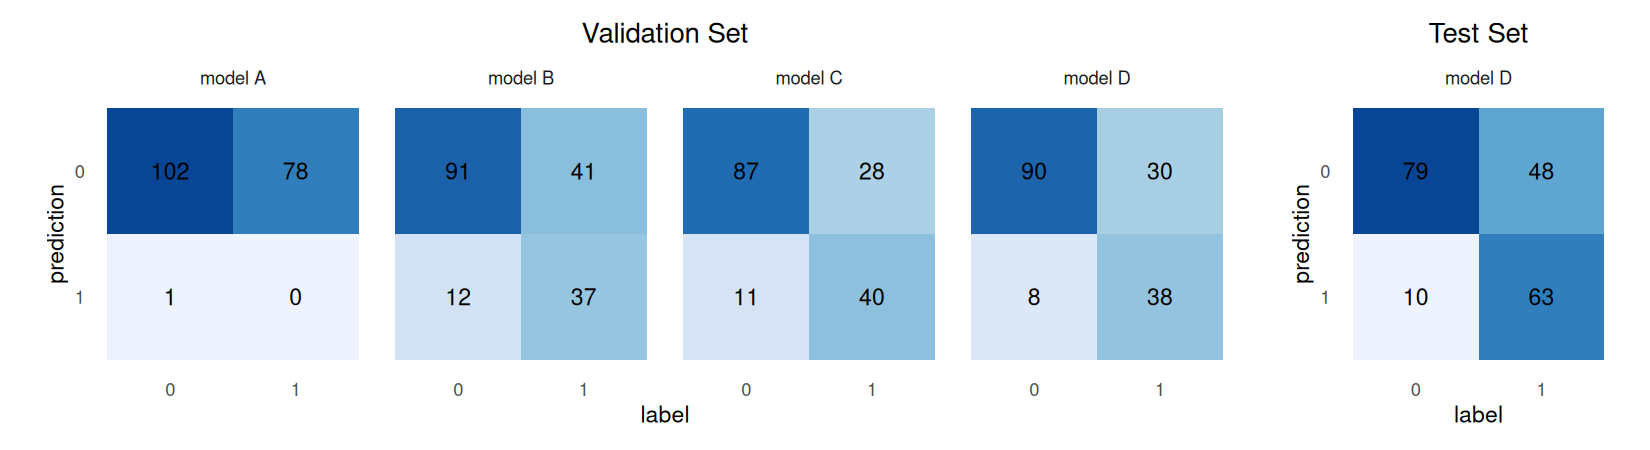

In [8]:
plt_val + plt_test + plot_layout(widths = c(4,1))

In [9]:
ggsave("analysis/confusion_matrix.svg", width = 11, height = 3)